### Piecewise linear models with pystan

Based on the following tutorial from Jan Vanhove: \
https://janhove.github.io/analysis/2018/07/04/bayesian-breakpoint-model

Useful reference when going between rstan and pystan: \
https://pystan.readthedocs.io/en/latest/differences_pystan_rstan.html

In [258]:
import numpy as np
import pandas as pd
import pystan as ps
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import plotly.express as px
import glob
import arviz
%matplotlib inline

pd.set_option('display.max_columns', None)  


In [259]:
# load the 10xv3 results with 30x sampling for each cell/depth combination
dfs={}
for item in glob.glob('./10xv3_final_summaries/*'):
    dfs[item.split('/')[2].split('-final_summary.csv')[0]] = pd.read_csv(item).sort_values(["sampled_cells", "total_UMIs"], ascending = (True, True))

In [5]:
df = dfs['10x_genomics_data-pbmc_1k_v3'][dfs['10x_genomics_data-pbmc_1k_v3']['sampled_cells']==999].copy()
df

,total_seqtk_reads,sampled_cells,validation_error,total_UMIs,estimated_reads,estimated_UMIs,reads_per_cell,UMIs_per_cell,duplication_rate,dataset
29,5000000,999,1259.6,1982354,4128099,1636670,4132,1638,2.52,pbmc_1k_v3
30,5000000,999,1491.1,1982354,4128099,1636670,4132,1638,2.52,pbmc_1k_v3
31,5000000,999,1043.2,1982354,4128099,1636670,4132,1638,2.52,pbmc_1k_v3
32,5000000,999,1488.8,1982354,4128099,1636670,4132,1638,2.52,pbmc_1k_v3
33,5000000,999,1328.2,1982354,4128099,1636670,4132,1638,2.52,pbmc_1k_v3
...,...,...,...,...,...,...,...,...,...,...
804,60998228,999,917.2,9728830,50361346,8032315,50411,8040,6.27,pbmc_1k_v3
805,60998228,999,816.1,9728830,50361346,8032315,50411,8040,6.27,pbmc_1k_v3
806,60998228,999,739.9,9728830,50361346,8032315,50411,8040,6.27,pbmc_1k_v3
807,60998228,999,841.0,9728830,50361346,8032315,50411,8040,6.27,pbmc_1k_v3


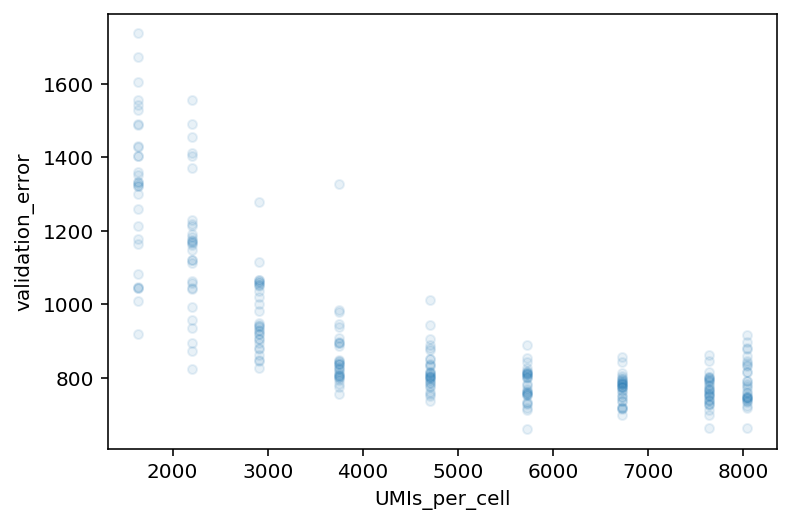

In [297]:
df.plot.scatter('UMIs_per_cell', 'validation_error', alpha = 0.1)
plt.show()

In [245]:
stan_model = ps.StanModel(file="seqdepth_piecewise_v1.stan", 
                          model_name = "seqdepth_piecewise_v1")


INFO:pystan:COMPILING THE C++ CODE FOR MODEL seqdepth_piecewise_v1_16109189d5a6f5181a31327d0c35ff91 NOW.


In [246]:

data_dict = {"umis_per_cell": np.log(df["UMIs_per_cell"]), "validation_error": np.log(df["validation_error"]), "N": len(df)}
stan_fit = stan_model.sampling(data=data_dict,
                               iter=4000,
                              control={'adapt_delta':1})

In [286]:
s = stan_fit.summary()
summary = pd.DataFrame(s['summary'], columns=s['summary_colnames'], index=s['summary_rownames'])
summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
intercept,6.705527,0.000246,0.015242,6.677906,6.695219,6.704814,6.715085,6.737481,3839.334737,1.000603
slope_before,-0.500149,0.000499,0.034576,-0.569065,-0.523219,-0.500239,-0.476458,-0.434134,4796.354536,1.000463
slope_after,-0.095368,0.000403,0.026390,-0.147357,-0.112905,-0.095854,-0.078292,-0.043596,4281.542069,1.000361
bp,8.344205,0.000873,0.054304,8.245119,8.303581,8.343789,8.383751,8.444889,3869.963361,1.000631
before_variance,0.133872,0.000112,0.008646,0.118258,0.127831,0.133329,0.139436,0.151829,5911.433333,0.999741
...,...,...,...,...,...,...,...,...,...,...
conditional_mean[269],6.643198,0.000100,0.007945,6.627431,6.637932,6.643146,6.648572,6.658896,6328.332478,0.999972
conditional_mean[270],6.643198,0.000100,0.007945,6.627431,6.637932,6.643146,6.648572,6.658896,6328.332478,0.999972
slope_difference,0.404781,0.000639,0.046089,0.313871,0.373944,0.404450,0.436204,0.495145,5207.073836,1.000180
slope_ratio,0.192076,0.000846,0.056797,0.084603,0.154251,0.191664,0.228135,0.306657,4503.765087,1.000187


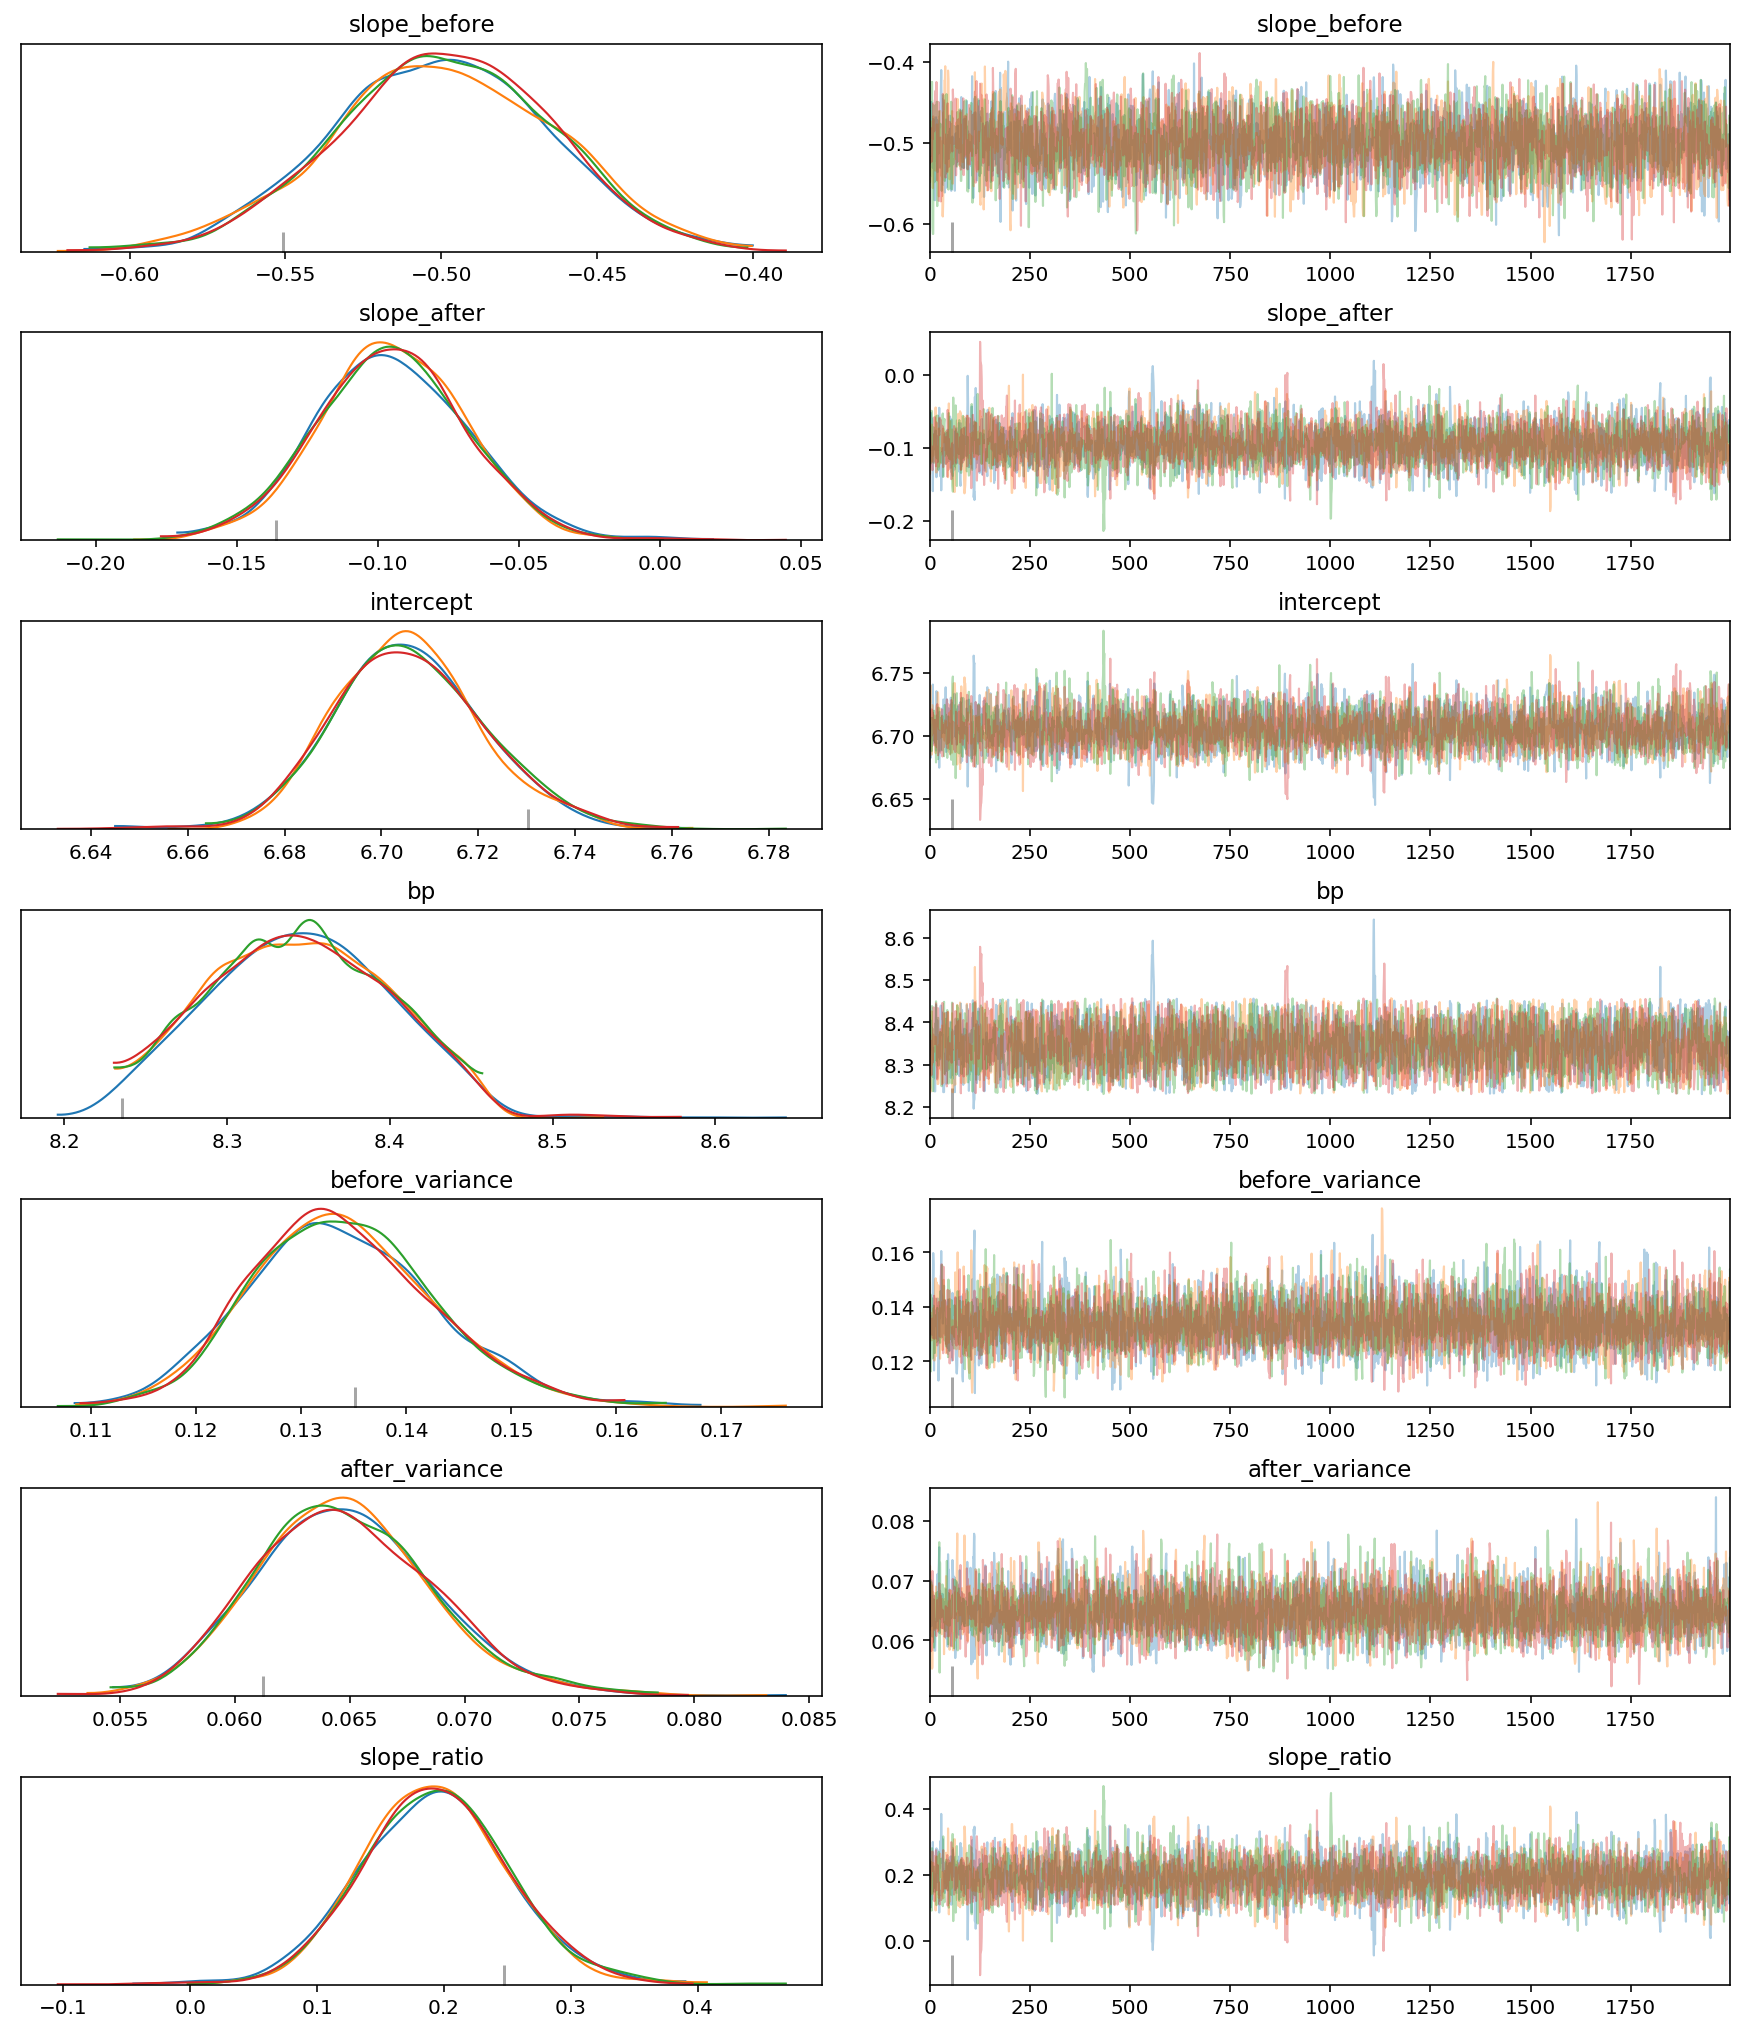

In [296]:
arviz.plot_trace(stan_fit,['slope_before','slope_after','intercept','bp','before_variance','after_variance','slope_ratio'])
plt.show()

In [274]:
stan_fit.to_dataframe()

,chain,draw,warmup,intercept,slope_before,slope_after,bp,before_variance,after_variance,conditional_mean[1],...,conditional_mean[270],slope_difference,slope_ratio,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,6.705629,-0.525615,-0.107845,8.322238,0.117871,0.062480,7.189723,...,6.633379,0.417770,0.205179,512.141652,0.751696,0.287368,3,15,0,-508.572787
1,0,1,0,6.702722,-0.503071,-0.090486,8.330924,0.123983,0.064883,7.170424,...,6.642887,0.412585,0.179867,514.392612,0.810357,0.287368,3,7,0,-510.917397
2,0,2,0,6.708986,-0.472816,-0.102912,8.341334,0.136760,0.062288,7.153482,...,6.642006,0.369904,0.217657,514.115958,0.942983,0.287368,4,15,0,-513.505018
3,0,3,0,6.682612,-0.516352,-0.052317,8.404103,0.132159,0.063977,7.200448,...,6.651845,0.464035,0.101321,512.741161,0.852202,0.287368,3,11,0,-510.703950
4,0,4,0,6.687253,-0.449871,-0.058286,8.382061,0.133364,0.070033,7.128500,...,6.651691,0.391585,0.129561,509.912112,0.764773,0.287368,4,15,0,-508.472873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,3,1995,0,6.740996,-0.526867,-0.143419,8.242238,0.130193,0.062704,7.184094,...,6.633439,0.383447,0.272212,513.038587,0.650454,0.269026,4,23,0,-511.796771
7996,3,1996,0,6.726202,-0.578197,-0.129472,8.246129,0.131518,0.067897,7.214720,...,6.629609,0.448725,0.223923,511.314567,0.240874,0.269026,4,15,0,-507.725874
7997,3,1997,0,6.729078,-0.575498,-0.127683,8.255630,0.130393,0.068356,7.220782,...,6.635032,0.447815,0.221865,511.478299,0.285861,0.269026,3,7,0,-510.860927
7998,3,1998,0,6.682800,-0.469312,-0.097922,8.452774,0.136492,0.060280,7.176302,...,6.629980,0.371390,0.208650,510.164623,0.085338,0.269026,5,63,0,-506.752641


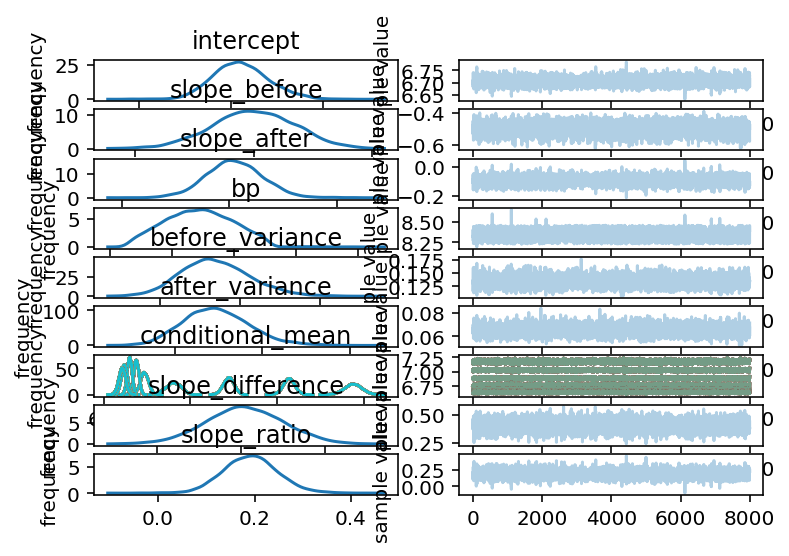

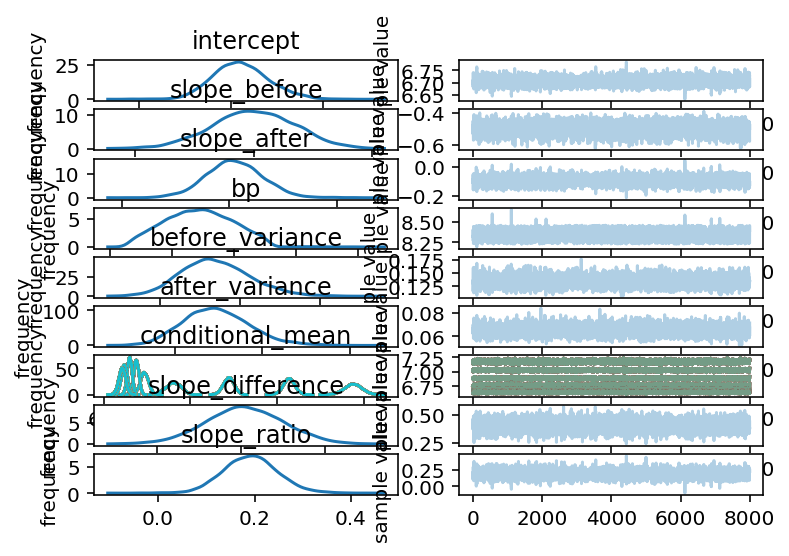

In [277]:
stan_fit.traceplot()

In [248]:
dope = stan_fit.extract()


In [249]:
dope.keys()

odict_keys(['intercept', 'slope_before', 'slope_after', 'bp', 'before_variance', 'after_variance', 'conditional_mean', 'slope_difference', 'slope_ratio', 'lp__'])

slope_before 0.034574129844575995


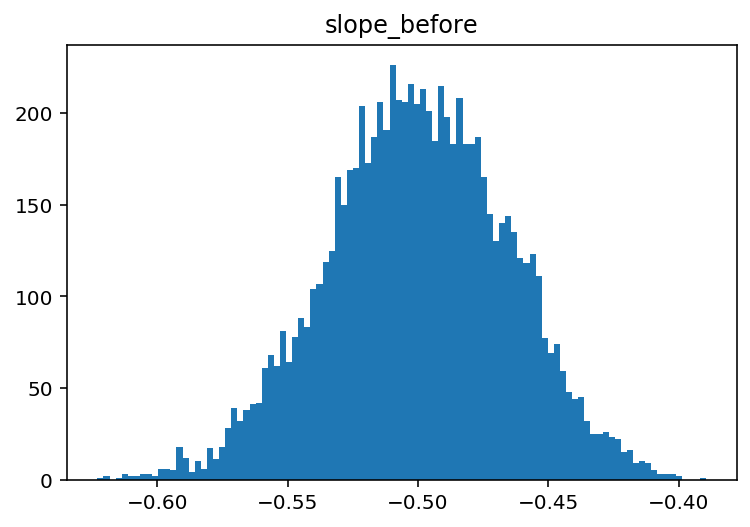

slope_after 0.026388779081051476


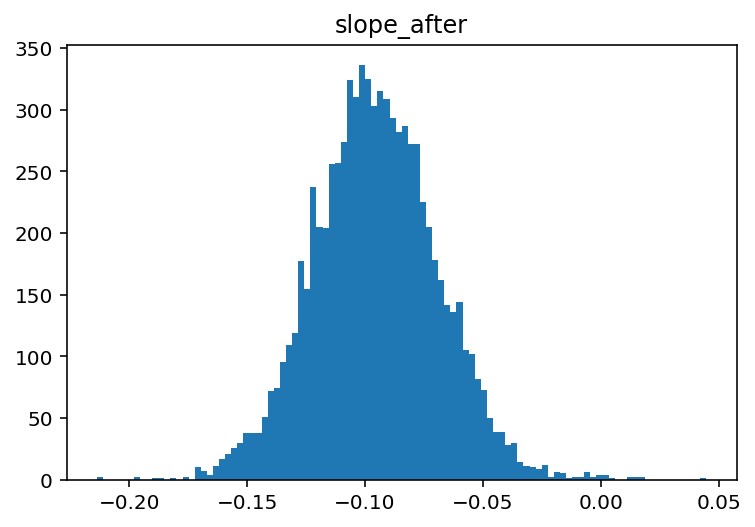

intercept 0.015240738645875123


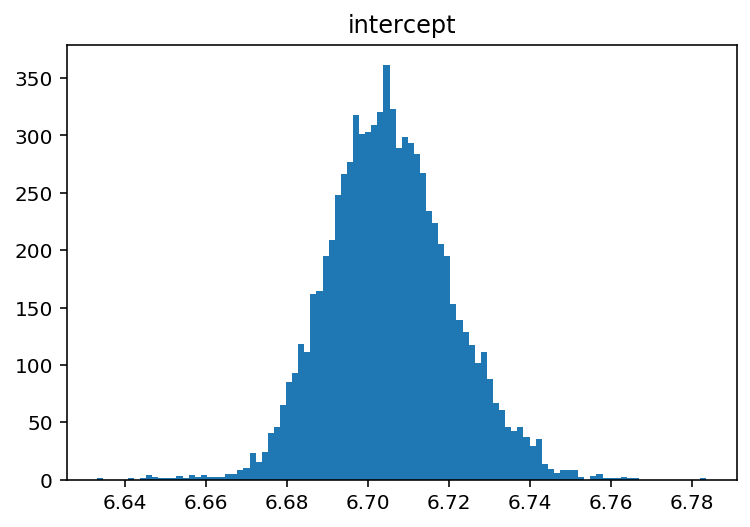

bp 0.05430021421130194


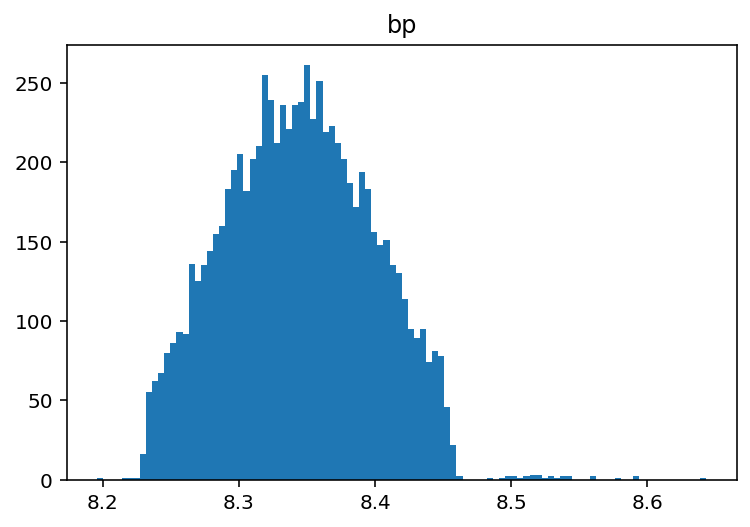

before_variance 0.00864560253147057


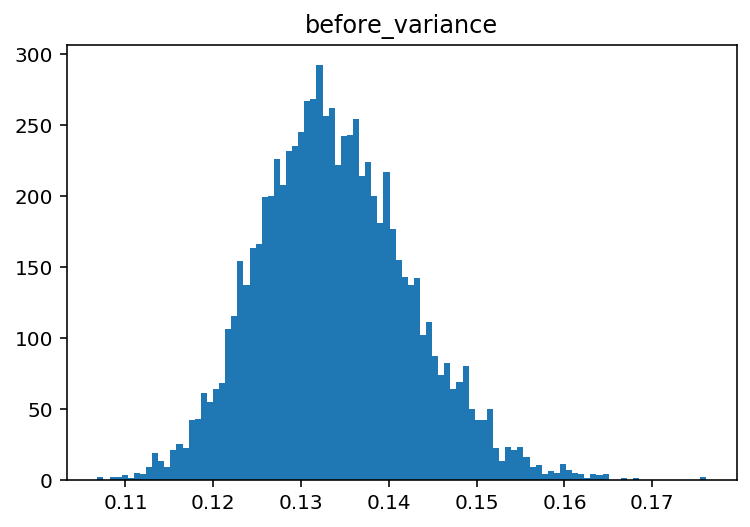

after_variance 0.003806405154546646


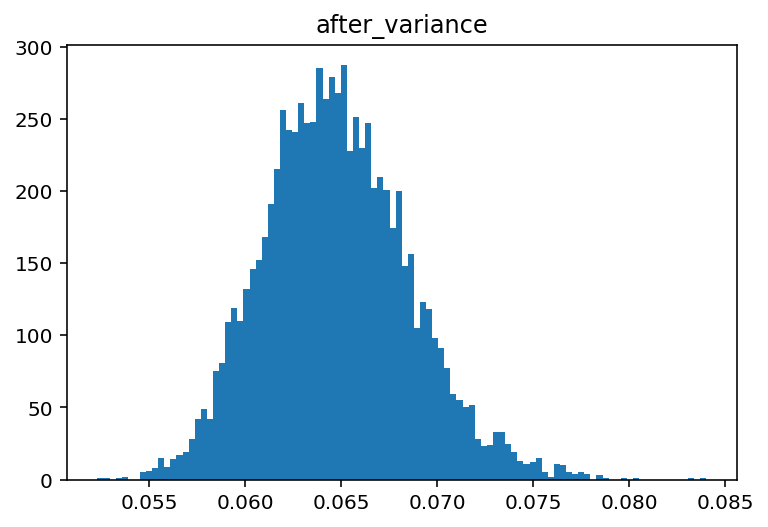

In [250]:
for thing in ['slope_before','slope_after','intercept','bp','before_variance','after_variance']:
    print(thing,np.std(dope[thing]))
    plt.hist(dope[thing], bins = 100)
    plt.title(thing)
    plt.show()

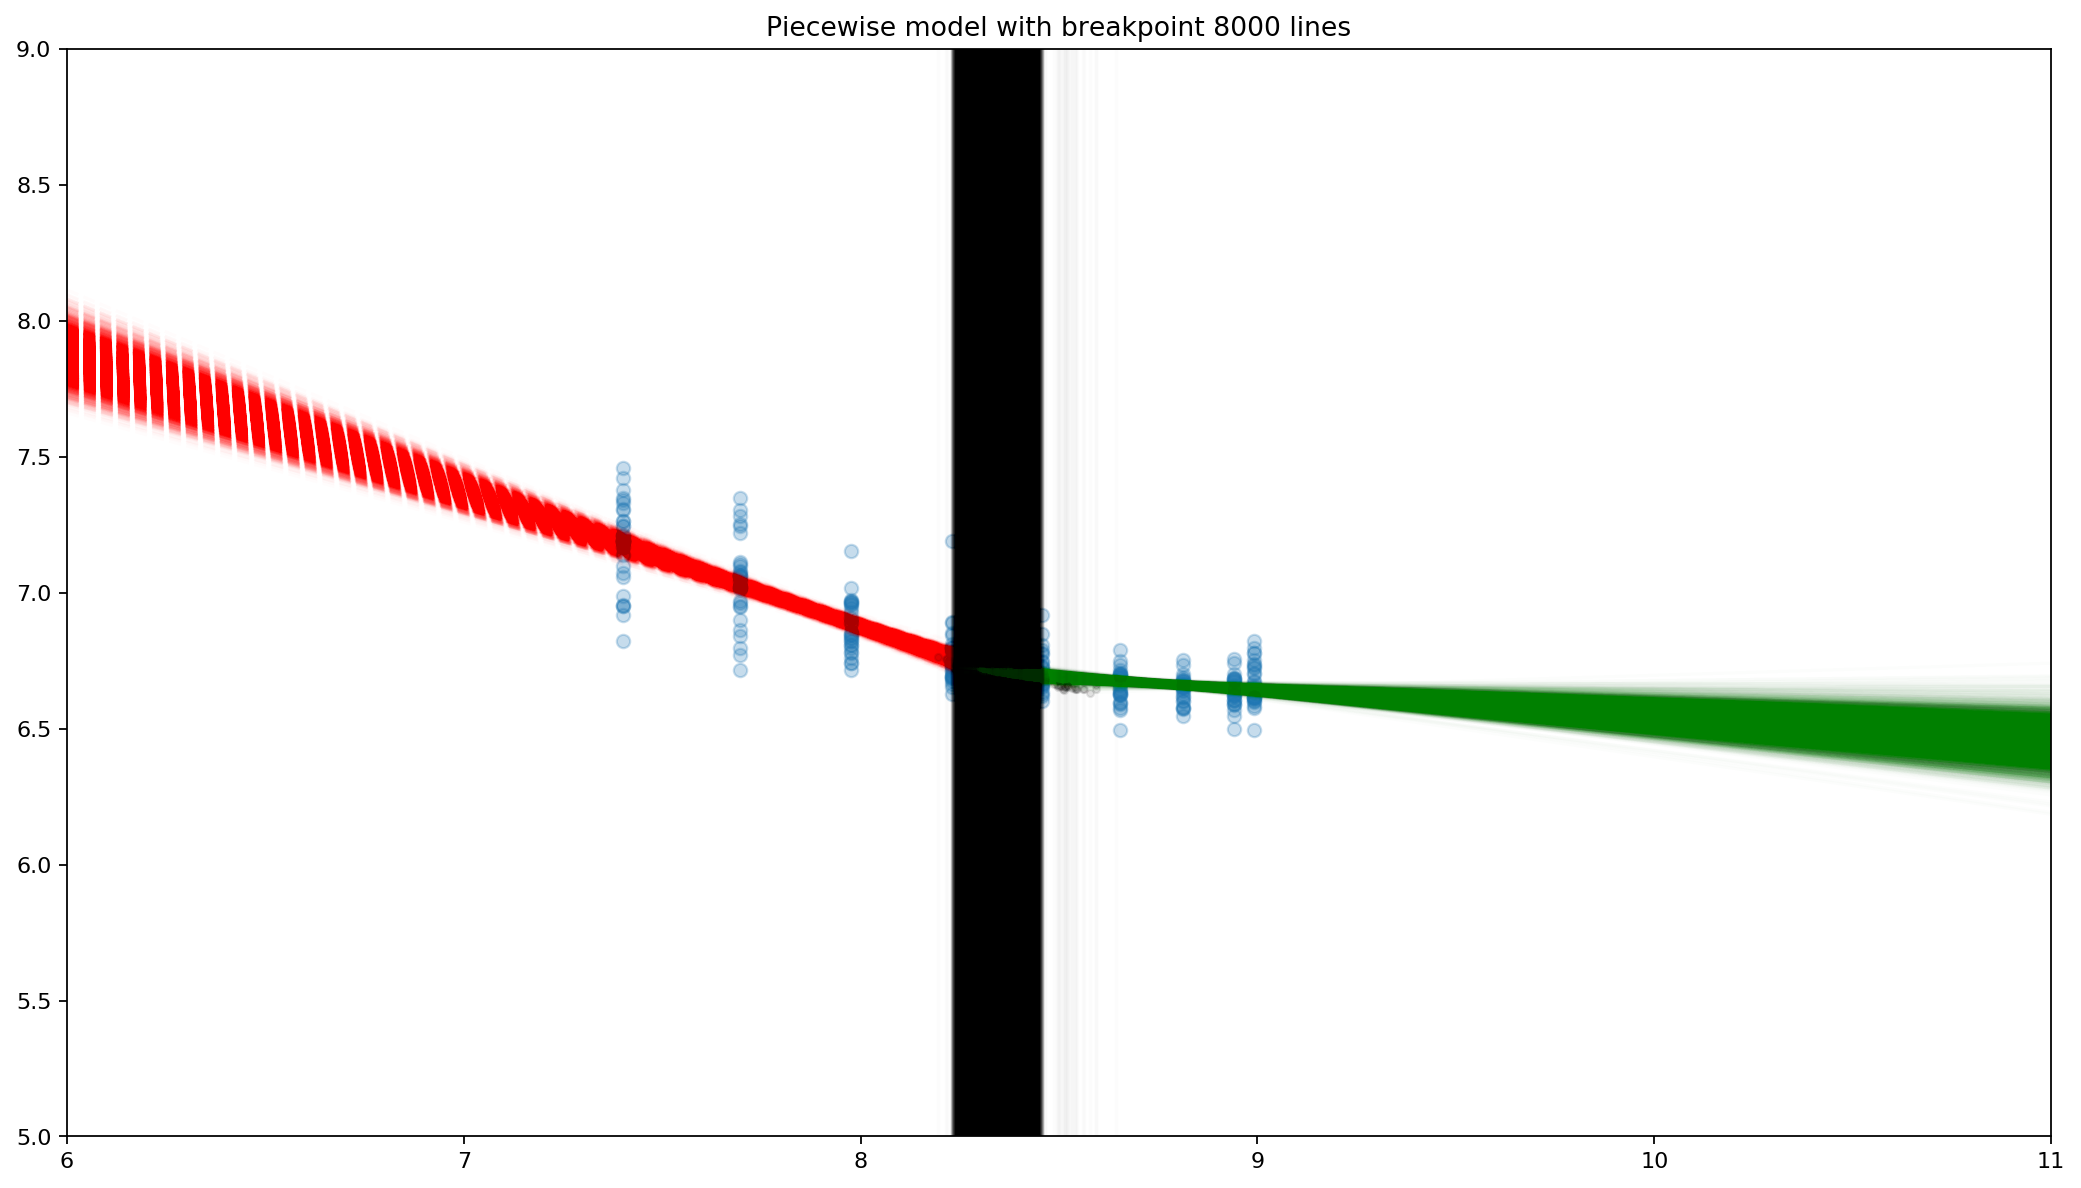

In [291]:
plt.figure(num=None, figsize=(16, 9), dpi=80, facecolor='w', edgecolor='k')
plt.ylim(5, 9)
plt.xlim(6, 11)
nlines = 8000
for intercept,slope,breakpoint in zip(dope['intercept'][0:nlines],dope['slope_before'][0:nlines],dope['bp'][0:nlines]):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    x_vals[1]=breakpoint
    y_vals = intercept + slope * (x_vals-breakpoint)
    plt.plot(x_vals, y_vals, '--', color = 'red', alpha = 0.01)
    
for intercept,slope,breakpoint in zip(dope['intercept'][0:nlines],dope['slope_after'][0:nlines],dope['bp'][0:nlines]):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    x_vals[0]=breakpoint
    y_vals = intercept + slope * (x_vals-breakpoint)
    plt.plot(x_vals, y_vals, '-', color='green', alpha = 0.01)
    plt.axvline(x=breakpoint,linestyle='-',color='black', alpha =0.01)
    plt.scatter(breakpoint,intercept, color = 'black', alpha = 0.1, s =10)
    
# plt.scatter(df['UMIs_per_cell'],df['validation_error'], alpha = 0.25)
plt.scatter(np.log(df["UMIs_per_cell"]),  np.log(df["validation_error"]), alpha = 0.25)

plt.title('Piecewise model with breakpoint '+ str(nlines)+' lines')
plt.show()


In [290]:
summary.head(6)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
intercept,6.705527,0.000246,0.015242,6.677906,6.695219,6.704814,6.715085,6.737481,3839.334737,1.000603
slope_before,-0.500149,0.000499,0.034576,-0.569065,-0.523219,-0.500239,-0.476458,-0.434134,4796.354536,1.000463
slope_after,-0.095368,0.000403,0.026390,-0.147357,-0.112905,-0.095854,-0.078292,-0.043596,4281.542069,1.000361
bp,8.344205,0.000873,0.054304,8.245119,8.303581,8.343789,8.383751,8.444889,3869.963361,1.000631
before_variance,0.133872,0.000112,0.008646,0.118258,0.127831,0.133329,0.139436,0.151829,5911.433333,0.999741
after_variance,0.064750,0.000050,0.003807,0.057856,0.062103,0.064567,0.067185,0.073031,5726.504922,0.999640
